# Regression problem

The task is to predict the median price of a house on a given district in California, given past records on sold properties in this US state.

In [1]:
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_theme(palette="Set2")

# Step 1. Load the data

If the data has not been downloaded before, download it, and save to a local folder called "datasets".

In [2]:
import os
import tarfile
import urllib


# the file is archived with tar and gunzip
URL = "https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"

def get_dataframe():
    global URL
    
    # if the "datasets" folder does not exist, create it
    if not os.path.exists("datasets"):
        os.makedirs("datasets")
    
    # if the archived file does not exist, download it
    if not os.path.exists("datasets/housing.tgz"):
        urllib.request.urlretrieve(URL, "datasets/housing.tgz")
    
    # if the unpacked file does not exist, unpack it
    if not os.path.exists("datasets/housing.csv"):
        infile = tarfile.open("datasets/housing.tgz")
        infile.extractall(path="datasets")
        infile.close()
    
    # load the dataframe
    return pd.read_csv("datasets/housing.csv")

In [3]:
df = get_dataframe()

In [4]:
# inspect the first couple of rows
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row describes a district, its geographical coordinates, mean age of houses, total number of rooms in the district, total number of bedrooms, the population of the district, the number of households (i.e. separate properties) in the district, etc.

In [5]:
# the size of the dataset
df.shape

(20640, 10)

There are 20,640 rows and 10 columns.

# Step 2. Train-test split

We should set aside a test part of the dataset as soon as possible, in order to avoid **data snooping** bias: Exploring test data may suggest to us specific solutions (data preprocessing steps or choice of the learning algorithm) and thus result in over-fitting the model to test data too, i.e. an over-optimistic evaluation of its accuracy.

## Random sampling

One option is to **randomly** split the full dataset into a training and test part:

In [6]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=7)
print(f"{train_set.shape[0]} train and {test_set.shape[0]} test instances")

16512 train and 4128 test instances


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Here, we requested that the test set is 20% of the full dataset (by passing `test_size=0.2`) and that the random number generator uses the same seed number (by passing `random_state=7`, any constant will do, as long as it is the same in different calls of the function). The latter ensures that if we run the same function again, the same train-test split will be produced.

Random sampling works well for very large datasets, but the smaller the dataset, the greater sampling there will be.

## Stratified sampling

Stratified sampling aims to ensure that some critical attribute(s) of the population are correctly represented in the sample. For example, if the general population of a country is composed of 51.3% females and 48.7% males, the gender attribute is important in our study, and our sample must have 1000 observations, then we should ensure that there are 513 females and 487 males in the sample. Otherwise, random sampling may introduce an undesired bias into our sample.

Suppose that the property agency indicated to us that the income of the population is a very important attribute. We can then split the data into the training and test sets, creating several income categories of observations and using them for stratified sampling.

We can use the `cut()` method to create a categorical variable in the dataframe that would record the groups of income. Here we create five income groups:

In [7]:
df["income_cat"] = pd.cut(df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                          labels=[1, 2, 3, 4, 5])

We can plot the distribution of the frequencies of each group to make sure each is sufficiently large and the same proportion of group sizes can be achieved after the train-test split.

In [8]:
df["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

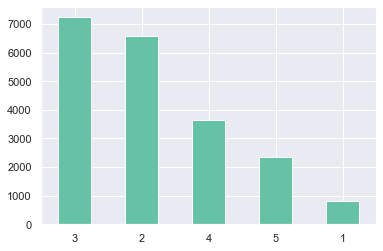

In [9]:
df["income_cat"].value_counts().plot(kind="bar", rot=0)

Now we can perform stratified sampling.

In [10]:
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, random_state=7,
                                                  stratify=df["income_cat"])

We can look at the income category proportions in the full dataset, in the test set produced with random sampling, and in the test set produced with stratified sampling:

In [11]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# create a random split
rand_train_set, rand_test_set = train_test_split(df, test_size=0.2, random_state=7)

# create a temporary dataframe for easy visualization
df_tmp = pd.DataFrame({
    "Overall": income_cat_proportions(df),
    "Random test set": income_cat_proportions(rand_test_set),
    "Stratified test set": income_cat_proportions(strat_test_set),
}).sort_index()

# add two columns for the percent of the difference to the overall proportion
df_tmp["Rand. %error"] = 100 * df_tmp["Random test set"] / df_tmp["Overall"] - 100
df_tmp["Strat. %error"] = 100 * df_tmp["Stratified test set"] / df_tmp["Overall"] - 100

df_tmp

,Overall,Random test set,Stratified test set,Rand. %error,Strat. %error
1,0.039826,0.039971,0.039971,0.364964,0.364964
2,0.318847,0.297481,0.318798,-6.701109,-0.015195
3,0.350581,0.358043,0.350533,2.128248,-0.013820
4,0.176308,0.188953,0.176357,7.172300,0.027480
5,0.114438,0.115552,0.114341,0.973751,-0.084674


So random splitting produces a test set where income category 2 is under-represented by 6% compared to its proportion in the overall dataset, and categories 3 and 4 are over-represented by 2% and 7%, respectively.

Stratification sampling resulted in under- or over-representations of income categories of no more than 0.25%.

Now that we have created stratified samples, we can delete the "income_cat" column in both subsets of data:

In [12]:
del strat_train_set["income_cat"]
del strat_test_set["income_cat"]

For convenience, let's rename the variables to shorter names:

In [13]:
trainset = strat_train_set
testset = strat_test_set

# Step 3. Exploratory Data Analysis

## Columns and their data types

Let's inspect the size of the dataset, the columns and their data types.

In [14]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 8088 to 2786
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16356 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In the "total_bedrooms" column, the number of non-null values is smaller than the number of rows, which suggests there are missing values that will need to be dealt with.

## Descriptive statistics

The data type of all the columns is numerical, except "ocean_proximity", which is a categorical variable. We can view all possible values of the column:

In [15]:
trainset['ocean_proximity'].value_counts()

<1H OCEAN     7307
INLAND        5269
NEAR OCEAN    2114
NEAR BAY      1817
ISLAND           5
Name: ocean_proximity, dtype: int64

To understand the distribution of the numerical values, one can use the `describe()` method of a dataframe:

In [16]:
trainset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16356.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.573100,35.637304,28.698886,2626.351623,535.972243,1418.784944,497.814983,3.867893,207136.547602
std,2.000532,2.133814,12.559323,2147.169862,414.717072,1082.348875,376.209950,1.899566,115413.047088
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1453.750000,297.000000,790.000000,280.000000,2.558225,119900.000000
50%,-118.500000,34.260000,29.000000,2125.000000,435.000000,1166.500000,409.000000,3.537150,180400.000000
75%,-118.010000,37.720000,37.000000,3136.250000,644.000000,1724.000000,603.000000,4.736900,265125.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


Another way to inspect the distribution of the variables is to plot histograms. One can plot a histogram for all numerical variables by calling the `hist()` method on the dataframe:

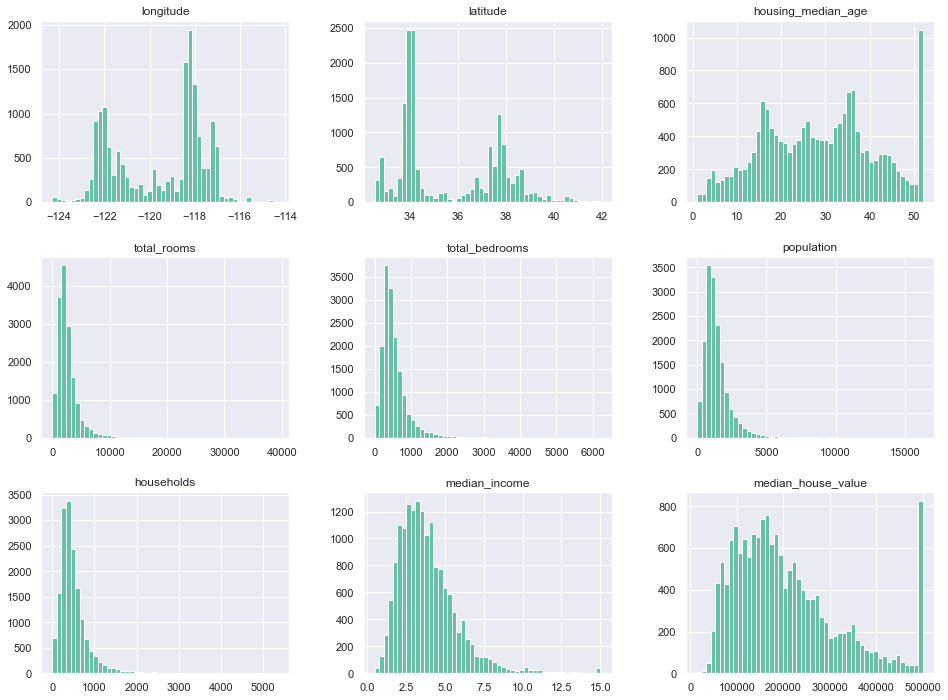

In [17]:
dummy = trainset.hist(bins=50, figsize=(16,12))

Things that can be noted:

* The median house age and median house value have a lot of observations at the right of the histogram. This suggests the data was **capped**. We can confirm this printing sorted values in the column:

In [18]:
trainset["median_house_value"].sort_values(ascending=False)

15702    500001.0
5247     500001.0
18339    500001.0
18052    500001.0
10679    500001.0
           ...   
13889     22500.0
5887      17500.0
19802     14999.0
2521      14999.0
2799      14999.0
Name: median_house_value, Length: 16512, dtype: float64

It appears all values greater than 500,000 were replaced with 500,001. Since house value is our target variable, we can either (1) collect uncapped data or (2) remove the capped data from the dataset at the data cleaning stage.
    
* All variables have very different scales (e.g., median income ranges between 0 and 15, while median house value between 0 and 500,000). This may be a problem for some algorithms and the variables may need to be scaled to be within the same range.
    
* Most of the variables do not seem to be normally distributed, and are right-tail heavy. One way to deal with some values being too far distributed to the right of the mean is to take their logarithms.

## Visualizing geographical data

We have the lattitude and longitude data, so we can use a scatterplot to visualize the geographical data (the alpha argument controlls the degree of transparency so it's easier to see high-density points):

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

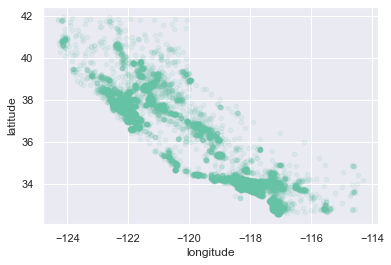

In [19]:
trainset.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

A lot of the population is on the coast (San Francisco and Los Angeles) as well as in the Central Valley inland.

Now let's look at the housing prices on the map.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

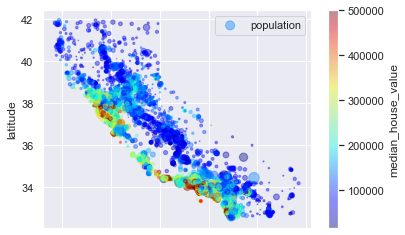

In [20]:
trainset.plot(kind="scatter",
            x="longitude",
            y="latitude", 
            alpha=0.4,                    # transparency
            s=trainset["population"]/100, # radius of each dot: population in the district
            label="population",
            c="median_house_value",       # colour of the dot: house value
            cmap=plt.get_cmap("jet"),    # colour map to use
            colorbar=True,                # show the color map
)

The plot suggests the most expensive housing is on the coast, except the Northern part of the state. The prices inland are noticeably lower. This suggests that the attribute "ocean_proximity" can indeed be useful for predicting house prices.

Another way to capture these observations in a predictor variable would be to cluster the points by geographical proximity and use the cluster id as a nominal predictor.

## Variable correlations

We can find out which variables have a correlation with our target variable. The `corr()` method of the Pandas dataframe measures Pearson's $r$ correlation in all pairs of numerical variables. The method returns a dataframe with measures. We can retrieve the correlations with "median_house_value" by checking the corresponding column:

In [21]:
corr_matrix = trainset.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686289
total_rooms           0.135723
housing_median_age    0.109030
households            0.066404
total_bedrooms        0.050819
population           -0.024405
longitude            -0.045513
latitude             -0.145896
Name: median_house_value, dtype: float64

The variable with by far the strongest correlation is "median_income". Other variables that may have some effect on house price are the latitude (negatively correlated, the further up north, the lower the price tends to be), the total number of rooms and the house age.

Based on the correlation coefficient values we could further select the most informative variables, deleting say the bottom 50% of variables sorted by the absolute value of the coefficent.

Note though that Pearson's coefficient measures linear correlation, and will miss any non-linear relationships that may exist between variables.

Another way to check correlations between variables is to use a **scatter matrix**, which will help to spot any non-linear relationships:

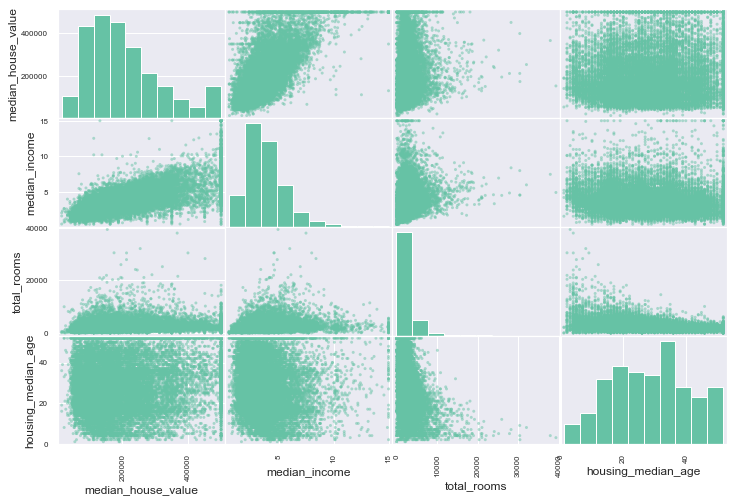

In [22]:
from pandas.plotting import scatter_matrix

# select only the variables that are most likely to be correlated
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
dummy = scatter_matrix(trainset[attributes], figsize=(12, 8))

The median_income variable appears to have the strongest correlation with the house value. Note also that the variable has been capped at 500,001 (which can be seen from the plot), so an extra cleaning step may be to delete all rows where median income is equal to or greater 500,001.

# Step 4. Data cleaning and transformation

## Feature engineering

There are a few variables that do not seem to be useful on their own: the total number of rooms, the total number of households, and the population in a district do not seem to be relevant to the price of a house. What might matter is how many rooms per household there are (the more rooms per property, the more expensive the property is likely to be), and how many people live in each property (the more people in a property on average, the less expensive it is likely to be). So we can create two additional variables:

In [23]:
trainset["rooms_per_household"] = trainset["total_rooms"]/trainset["households"]
trainset["population_per_household"] = trainset["population"]/trainset["households"]

Let's check the correlation with the target variable again:

In [24]:
corr_matrix = trainset.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.686289
rooms_per_household         0.147401
total_rooms                 0.135723
housing_median_age          0.109030
households                  0.066404
total_bedrooms              0.050819
population_per_household   -0.021876
population                 -0.024405
longitude                  -0.045513
latitude                   -0.145896
Name: median_house_value, dtype: float64

It seems "rooms_per_household" is in fact one of the most strongly correlated variables!

Create the same two extra columns also in the **test set**:

In [25]:
testset["rooms_per_household"] = testset["total_rooms"]/testset["households"]
testset["population_per_household"] = testset["population"]/testset["households"]

## Missing values

As noted before, "total_bedrooms" has 156 missing values. 

In [26]:
trainset['total_bedrooms'].isnull().sum()

156

Before the data can be used for training and testing, we can either (1) delete the corresponding rows, (2) delete the entire column, or (3) impute missing values (i.e., replace them with the mean, median, zero, etc).

There are not many missing values, so it makes sense not to delete the whole column and impute them instead, using, say, the median value in the column.

In [27]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# we create a temporary dataframe with only numerical columns, 
# but keep the categorical columns in a separate variable
trainset_categorical = trainset["ocean_proximity"].values
trainset_numerical = trainset.drop("ocean_proximity", axis=1)

We first need to "fit" the imputer on the **training data**. When `fit()` is called, imputer finds the median for all the columns and stores them as internal attributes:

In [28]:
imputer.fit(trainset_numerical)

SimpleImputer(strategy='median')

Then we can do the replacements. When `transform()` is called, imputer replaces missing values with the median:

In [29]:
transformed = imputer.transform(trainset_numerical)

Note the last two steps could have been achieved by just calling `fit_transform()`.

The replaced values are a NumPy array. It needs to be put back into the dataframe, this can be done like this:

In [30]:
trainset = pd.DataFrame(transformed, columns=trainset_numerical.columns)

# add the categorical variable back
trainset['ocean_proximity'] = trainset_categorical

# check if there are missing values again
trainset.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
rooms_per_household         0
population_per_household    0
ocean_proximity             0
dtype: int64

To impute missing values also in the **test set**, we need to use the imputer fitted on the training data. So we only call the transform (but not `fit()` and not `fit_transform()`):

In [31]:
testset_categorical = testset["ocean_proximity"].values
testset_numerical = testset.drop("ocean_proximity", axis=1)

transformed = imputer.transform(testset_numerical)

testset = pd.DataFrame(transformed, columns=testset_numerical.columns)

# add the categorical variable back
testset['ocean_proximity'] = testset_categorical

# check if there are missing values again
testset.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
rooms_per_household         0
population_per_household    0
ocean_proximity             0
dtype: int64

No missing values remain either in the train or test set.

## Create dummy variables

The "ocean_proximity" variable is the only categorical variable. We can create dummy variables from it using `OneHotEncoder` from scikit-learn (it is more suitable than `get_dummies` from Pandas, as it creates dummies from training data and then applies the same transformations to test data):

In [32]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop="first", sparse=False)

# categorical columns to transform
cat_cols = ["ocean_proximity"]

# fit an encoder and transform the **trainset**
cat_vals = trainset[cat_cols].to_numpy()
transformed = one_hot_encoder.fit_transform(cat_vals)

# the names of the new columns are the unique values of "ocean_proximity"
new_col_names = one_hot_encoder.get_feature_names_out(cat_cols)

# put the transformed data as columns in the trainset dataframe
for i, new_col_name in enumerate(new_col_names):
    trainset[new_col_name] = transformed[:,i]

# check if the dummies are produced correctly in the trainset
trainset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,ocean_proximity,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-118.21,33.82,34.0,1719.0,398.0,1444.0,372.0,2.8438,139300.0,4.620968,3.881720,NEAR OCEAN,0.0,0.0,0.0,1.0
1,-117.27,33.03,25.0,1787.0,311.0,1108.0,311.0,3.9826,215800.0,5.745981,3.562701,NEAR OCEAN,0.0,0.0,0.0,1.0
2,-122.08,37.68,26.0,1167.0,370.0,253.0,137.0,2.4196,275000.0,8.518248,1.846715,NEAR BAY,0.0,0.0,1.0,0.0
3,-121.45,38.70,24.0,2159.0,369.0,1141.0,355.0,3.9853,90400.0,6.081690,3.214085,INLAND,1.0,0.0,0.0,0.0
4,-122.10,37.39,35.0,2471.0,349.0,881.0,342.0,7.6229,500001.0,7.225146,2.576023,NEAR BAY,0.0,0.0,1.0,0.0


In [33]:
# delete the categorical column
del trainset['ocean_proximity']

Create dummies in the **test set** using the fitted encoder. As before, we call `transform()`, but not `fit()` or `fit_transform()`:

In [34]:
# transform the **testset** using the encoder fitted on trainset
cat_vals = testset[cat_cols].to_numpy()
transformed = one_hot_encoder.transform(cat_vals)

# put the transformed data as columns in the testset dataframe
for i, new_col_name in enumerate(new_col_names):
    testset[new_col_name] = transformed[:,i]
    
# check if the dummies are produced correctly in the testset
testset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_per_household,ocean_proximity,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.22,40.18,13.0,3719.0,803.0,1754.0,764.0,2.3517,88900.0,4.867801,2.295812,INLAND,1.0,0.0,0.0,0.0
1,-121.81,37.29,15.0,5957.0,1037.0,3838.0,997.0,6.2907,253100.0,5.974925,3.849549,<1H OCEAN,0.0,0.0,0.0,0.0
2,-122.26,38.02,5.0,3846.0,786.0,2053.0,716.0,5.0473,184800.0,5.371508,2.867318,NEAR BAY,0.0,0.0,1.0,0.0
3,-118.34,33.98,47.0,2649.0,684.0,2374.0,607.0,2.3882,137700.0,4.364086,3.911038,<1H OCEAN,0.0,0.0,0.0,0.0
4,-119.67,34.42,37.0,1673.0,444.0,1477.0,446.0,2.0643,246700.0,3.751121,3.311659,<1H OCEAN,0.0,0.0,0.0,0.0


In [35]:
# delete the categorical column also in the test set
del testset['ocean_proximity']

## Delete capped values

Let's delete rows where the value in the "median_house_value" has been replaced with 500,001.

In [36]:
def delete_capped(df, col_name, capped_val):
    return df.drop(df[df[col_name] >= capped_val].index)
    
print(f"Before: {trainset.shape[0]} train instances, {testset.shape[0]} test instances")

trainset = delete_capped(trainset, "median_house_value", 500001)
testset = delete_capped(testset, "median_house_value", 500001)

print(f"After: {trainset.shape[0]} train instances, {testset.shape[0]} test instances")

Before: 16512 train instances, 4128 test instances
After: 15735 train instances, 3940 test instances


## Feature scaling

With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required, and it's best to keep their original values so it is easier to interpret them.

There are two common ways to get all variables to have the same scale: **min-max scaling** and
**standardization**.

**Min-max scaling** (many people call this normalization) is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this.

**Standardization** is quite different: first it subtracts the mean value (so standardized values always have _a zero mean_ ), and then it divides by the variance so that the resulting distribution has _unit variance_.

Some algorithms (e.g., neural networks) require variables to be scaled to the 0-1 range. However, standardization is much less affected by outliers. Scikit-Learn provides a transformer called `StandardScaler` for standardization. We'll use it in this project.

>**Note**: As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (which would include the test set). Only then can you use them to transform the training set and the test set.

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

trainset_target = trainset["median_house_value"].values
trainset_predictors = trainset.drop("median_house_value", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.fit_transform(trainset_predictors)
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the non-scaled target back in
trainset['median_house_value'] = trainset_target

# inspect the data
trainset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,0.677040,-0.855558,0.445990,-0.415227,-0.335389,0.009348,-0.338056,-0.528521,-0.313152,0.063549,-0.707309,-0.017829,-0.343423,2.665046,139300.0
1,1.146465,-1.223491,-0.275199,-0.383516,-0.546026,-0.298400,-0.500095,0.197649,0.160504,0.036687,-0.707309,-0.017829,-0.343423,2.665046,215800.0
2,-1.255592,0.942189,-0.195067,-0.672641,-0.403180,-1.081510,-0.962306,-0.799017,1.327690,-0.107806,-0.707309,-0.017829,2.911858,-0.375228,275000.0
3,-0.940978,1.417241,-0.355331,-0.210042,-0.405601,-0.268175,-0.383214,0.199371,0.301845,0.007332,1.413809,-0.017829,-0.343423,-0.375228,90400.0
4,-1.165702,1.100540,-1.877841,-0.489373,-0.405601,-0.363430,-0.338056,-0.036500,-0.493105,-0.028577,1.413809,-0.017829,-0.343423,-0.375228,181800.0


Now use the fitted scaler to scale also the test data, again calling `transform()` on the fitted scaler:

In [38]:
testset_target = testset["median_house_value"].values
testset_predictors = testset.drop("median_house_value", axis=1)

scaled_vals = scaler.transform(testset_predictors)
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the non-scaled target back in
testset['median_house_value'] = testset_target

testset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
0,-1.325507,2.106533,-1.236784,0.517433,0.645163,0.293283,0.703246,-0.842314,-0.209230,-0.069990,1.413809,-0.017829,-0.343423,-0.375228,88900.0
1,-1.120758,0.760551,-1.076520,1.561078,1.211705,2.202055,1.322183,1.669438,0.256894,0.060840,-0.707309,-0.017829,-0.343423,-0.375228,253100.0
2,-1.345482,1.100540,-1.877841,0.576656,0.604004,0.567142,0.575740,0.876569,0.002842,-0.021867,-0.707309,-0.017829,2.911858,-0.375228,184800.0
3,0.612119,-0.781040,1.487707,0.018460,0.357051,0.861151,0.286194,-0.819040,-0.421305,0.066018,-0.707309,-0.017829,-0.343423,-0.375228,137700.0
4,-0.052067,-0.576115,0.686386,-0.436678,-0.224018,0.039573,-0.141483,-1.025579,-0.679377,0.015548,-0.707309,-0.017829,-0.343423,-0.375228,246700.0


# Train models

As discussed before, models are trained only on the training data.

First, create separate arrays for the predictors (`Xtrain`) and for the target (`ytrain`):

In [39]:
# drop labels for training set, but keep all others
Xtrain = trainset.drop("median_house_value", axis=1)

ytrain = trainset["median_house_value"].copy()

In [40]:
print(Xtrain.shape)
print(trainset.shape)

(15735, 14)
(15735, 15)


# Baseline

We'll use a simple baseline: for all test instances, predict the median value seen in the training data:

In [41]:
median_price = ytrain.median()
median_price

174100.0

Let's measure it in terms of RMSE:

In [42]:
from sklearn.metrics import mean_squared_error

# yhat will have the same number of rows as ytrain, 
# each cell will be filled with the same value, median_price
yhat = np.full((ytrain.shape[0], 1), median_price)

baseline_mse = mean_squared_error(ytrain, yhat)

# take square root
baseline_rmse = np.sqrt(baseline_mse)

baseline_rmse

99386.25261605746

I.e., the baseline is off by $99,386.25 on average.

## Training and evaluating on training data

### Linear regression

Let's begin with linear regression:

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(Xtrain, ytrain)

LinearRegression()

Look up the $R^2$ score for this model:

In [44]:
lin_reg.score(Xtrain, ytrain)

0.6125415917493089

Pretty good. Now let's find out the Root Mean Squared Error, on the **training set**:

In [45]:
# make predictions
yhat = lin_reg.predict(Xtrain)

lin_mse = mean_squared_error(ytrain, yhat)

# take square root
lin_rmse = np.sqrt(lin_mse)

lin_rmse

60774.07055524483

I.e., the predictions are off by $60,774.07 on average. Better than the baseline, but obviously not very useful yet. A linear model assumes there is a linear relationship between variables, which is rarely the case, and such a model often **underfits**, unable to capture complex patterns in the data.

We can also visualize the predictions and the true values. Because there are too many test instances, we'll show only the first 50.

<AxesSubplot:>

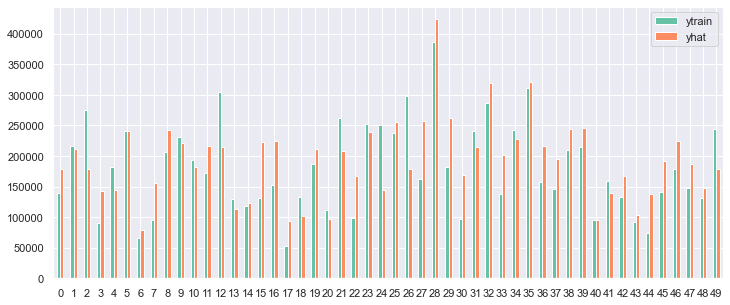

In [46]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

### Decision Trees

Now let's fit a Decision Trees regressor. This is a powerful algorithm, capable of finding complex
nonlinear relationships in the data.

In [47]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(Xtrain, ytrain)
yhat = tree_reg.predict(Xtrain)
tree_mse = mean_squared_error(ytrain, yhat)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The model makes no errors! Let's visualize the predictions.

<AxesSubplot:>

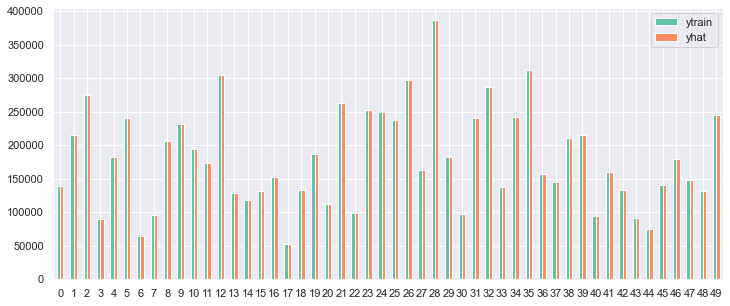

In [48]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

Indeed, the predictions are spot on! But, these are predictions on training data. Decision trees are powerful models, capable of capturing complex patterns in the data, but at the same time they will **overfit**, unless they are contrained in some way (e.g. a maximum tree depth is set). To confirm this, we would need to see how the model fares on the test data, but this needs to be postponed till after we have selected the most promising models for the eventual evaluation on the test set.

Another possibility is to evaluate the model using **cross-validation**.

## Cross-validation

The idea behind cross-validation is the following: take the training set, split it into $k$ parts (e.g., $k$=10). Then train a model on the $k-1$ parts and evaluate the model on the $k$-th part. Repeat this $k$ times, each time recording the accuracy score. The final accuracy score is the mean of the accuracy scores of the $k$ models.

In scikit-learn, this can be achieved as follows.

### Decision trees

In [49]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor()

# Scikit-Learn cross-validation features expect a utility function (greater is better) 
# rather than a cost function (lower is better), so the scoring function is actually 
# the opposite of the MSE
rmse_scores = -cross_val_score(tree_reg, Xtrain, ytrain, scoring="neg_root_mean_squared_error", cv=10)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [61174.346946   61250.56614111 61889.7932273  64373.40614774
 64230.78767331 63709.39869845 67932.00210771 63285.86633131
 62711.80895334 64209.22506915]
Mean: 63476.7201295416
Standard deviation: 1876.417840277121


Thus, the Decision Tree algorithm produces models that have the RMSE of 63,833.93; the standard deviation being 2,043 (which gives an idea of the variance of the algorithm).

So we can confirm that our original model, which was evaluated on the training set, overfitted the data.

### Linear regression

For comparison, let's also evaluate the linear regression using cross-validation:

In [50]:
lin_reg = LinearRegression()
rmse_scores = -cross_val_score(lin_reg, Xtrain, ytrain,
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(rmse_scores)

Scores: [60391.23908087 58558.61491325 62494.25085911 62032.13711681
 60868.52479896 59369.86555516 63651.45371733 61703.30866387
 59609.10907932 60790.13918702]
Mean: 60946.8642971698
Standard deviation: 1475.7676873343828


It turns out that linear regression has a slightly lower average error rate than Decision Trees, and at the same time exhibits lower variance.

### Random Forest

Finally, let's evaluate a RandomForest regression algorithm. Random Forests work by training many Decision Trees on random subsets of the features, then averaging out their predictions.

We specify that we want the algorithm to use 10 decision trees. We do that by passing `n_estimators=10` when we initialize the `RandomForestRegressor` class 

In [51]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=7)
rmse_scores = -cross_val_score(forest_reg, Xtrain, ytrain,
                         scoring="neg_root_mean_squared_error", cv=10)
display_scores(rmse_scores)

Scores: [46362.71504436 46592.32689625 47861.76298238 48110.05543239
 47056.27916163 47300.08736286 49938.2228861  49014.34477377
 46798.44881455 48124.59934161]
Mean: 47715.88426959181
Standard deviation: 1072.9207811127385


The algorithm produced a much lower RMSE score (47,715) than either Decision Trees or linear regression methods. It seems to be a particularly suitable algorithm to be explored further.

## Tuning hyperparameters

In the previous experiment, we used 10 decision trees in the Random Forest algorithm. This setting is called a hyperparameter of the algorithm, and needs to be set before a model is trained.

We might experiment with several different settings of the hyperparameter to find its optimal settings. However, many algorithms have quite a few of such hyperparameters. Scikit-learn has a utility to automatically search for the best combination of hyperparameter values, implemented in the `GridSearchCV` class. 

### Exhaustive grid search

`GridSearchCV` takes a set of hyperparameters and the search range for each hyperparameter, constructs a search grid with all possible hyperparameter combinations, and evaluates each combination using cross-validation. The output is the model with the best cross-validation accuracy.

Let's take a look at an example. We will train a RandomForest regressor, searching for the best model in the grid created from two hyperparameters: `n_estimators` (the number of decision trees, trying values 3, 10 and 30) and `max_depth` (the maximum depth of each tree, trying values 4, 6, 8 and None - None being the maximum possible depth, the default value). So, the grid search will involve creating and evaluating 12 models using cross-validation.

In [52]:
from sklearn.model_selection import GridSearchCV

# specify the hyperparameters and their values
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [4, 6, 8, None]
}

forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_root_mean_squared_error', 
                           return_train_score=True, verbose=2)

grid_search.fit(Xtrain, ytrain)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END ........................max_depth=4, n_estimators=3; total time=   0.0s
[CV] END .......................max_depth=4, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=4, n

[CV] END ....................max_depth=None, n_estimators=10; total time=   0.2s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.1s
[CV] END ....................max_depth=None, n_estimators=30; total time=   0.6s
[CV] END ....................max_depth=None, n_estimators=30; total time=   0.5s
[CV] END ....................max_depth=None, n_estimators=30; total time=   0.5s
[CV] END ...................

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=7),
             param_grid={'max_depth': [4, 6, 8, None],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

Once grid search is complete we can obtain the best model and its accuracy score: they are attributes on the `GridSearchCV` class:

In [53]:
grid_search.best_estimator_

RandomForestRegressor(n_estimators=30, random_state=7)

The best model proved to be one with `n_estimator=30` and `max_depth=None`.

Let's look up its RMSE.

In [54]:
-grid_search.best_score_

46204.58490177015

Thus by tuning hyperparameters, we were able to further reduce the error rate (from 47715 to 46204). 

You could have noticed that the largest value of `n_estimators` we tried (30) produced the best result. This suggests we should try even greater values - we could improve the error rate further.

We can also access RMSE scores of each model trained during grid search. They are stored in the `cv_results_` attribute:

In [55]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["mean_train_score"] = -cv_results["mean_train_score"]
cv_results["mean_test_score"] = -cv_results["mean_test_score"]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

cv_results.sort_values('mean_test_score')

,params,mean_train_score,mean_test_score,"diff, %"
11,"{'max_depth': None, 'n_estimators': 30}",18449.945407,46204.584902,-150.432096
10,"{'max_depth': None, 'n_estimators': 10}",20749.335861,47715.884270,-129.963429
8,"{'max_depth': 8, 'n_estimators': 30}",45068.344072,50638.694124,-12.359784
7,"{'max_depth': 8, 'n_estimators': 10}",45629.018368,50963.861722,-11.691778
6,"{'max_depth': 8, 'n_estimators': 3}",47578.721465,52922.420857,-11.231280
9,"{'max_depth': None, 'n_estimators': 3}",27263.517784,53677.305467,-96.883270
5,"{'max_depth': 6, 'n_estimators': 30}",52530.224017,54859.064650,-4.433335
4,"{'max_depth': 6, 'n_estimators': 10}",52781.305140,55078.149853,-4.351625
3,"{'max_depth': 6, 'n_estimators': 3}",53868.893594,56221.501782,-4.367285
2,"{'max_depth': 4, 'n_estimators': 30}",60633.648651,61370.369446,-1.215036


The best-performing model showed a much lower RMSE on the training set (18449) than on the validation set (46204). This indicates the model overfitted the training data. The overfitting could be reduced and the model further improved by introducing constraints on the learned trees (for example, enforcing a maximum depth of the learned trees).

### Randomized grid search

When the search space of hyperparameters is very large, running exhaustive grid search may take too much time. In such cases, one can try `RandomizedSearchCV` instead. It allows to limit the number of models to build and thus control the amount of computing resources one uses.

The class works very much the same as `GridSearchCV`, but takes extra arguments: `n_iter`, the number of random combinations to try and `random_state`, which can be set to the same constant to ensure that the same random combinations are tried in different runs of the code.

Here, we will try 6 random combinations (`n_iter=6`), instead of 12 in the exhaustive search.

In [56]:
from sklearn.model_selection import RandomizedSearchCV

# specify the hyperparameters and their values
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_depth': [4, 6, 8, None]
}

forest_reg = RandomForestRegressor(random_state=7)

# we'll use 10-fold cross-validation
rand_grid_search = RandomizedSearchCV(forest_reg, param_grid, cv=10, n_iter=6,
                                     scoring='neg_root_mean_squared_error', random_state=7,
                                     return_train_score=True, verbose=2)

rand_grid_search.fit(Xtrain, ytrain)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=10; total time=   0.0s
[CV] END ....................max_depth=None, n_estimators=10; total time=   0.3s
[CV] END ....................max_depth=None, n_e

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=7),
                   n_iter=6,
                   param_distributions={'max_depth': [4, 6, 8, None],
                                        'n_estimators': [3, 10, 30]},
                   random_state=7, return_train_score=True,
                   scoring='neg_root_mean_squared_error', verbose=2)

In [57]:
rand_grid_search.best_estimator_

RandomForestRegressor(n_estimators=10, random_state=7)

The best model found is with `n_estimators=10` and `max_depth=None`.

Its RMSE score is:

In [58]:
-rand_grid_search.best_score_

47715.88426959181

## Analyze the most promising models

We can examine what variables were the most important for the regression problem in the best-performing model. They are also stored as an attribute on the model object:

In [59]:
# put them into a separate variable for convenience
feature_importances = grid_search.best_estimator_.feature_importances_

# the order of the features in `feature_importances` is the same as in the Xtrain dataframe,
# so we can "zip" the two and print in the descending order:

for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k:.3f}")

median_income: 0.412
INLAND: 0.159
population_per_household: 0.113
longitude: 0.094
latitude: 0.072
housing_median_age: 0.051
rooms_per_household: 0.035
total_rooms: 0.029
total_bedrooms: 0.014
population: 0.012
households: 0.007
NEAR OCEAN: 0.003
NEAR BAY: 0.000
ISLAND: 0.000


We can notice that median income is by far the most useful variable for predicting the price of housing. Other useful features are the position of the district relative to the ocean, the average number of persons per household in a district.

There are some features that are much less useful: "NEAR OCEAN", "NEAR BAY" and "ISLAND". We may consider removing them both from the training and test set.

It often helps to also visualize the predictions made by the model. Let's refit the best model on the first 90% of the training set and generate predictions on the last 10%. There are 15736 training instances, so we will use 14162 for training and the rest for testing.

In [60]:
type(Xtrain)

pandas.core.frame.DataFrame

In [61]:
forest_reg = RandomForestRegressor(n_estimators=30, max_depth=None)
tree_reg.fit(Xtrain.values[:14163,:], ytrain.values[:14163])
yhat = tree_reg.predict(Xtrain.values[14163:, :])

<AxesSubplot:>

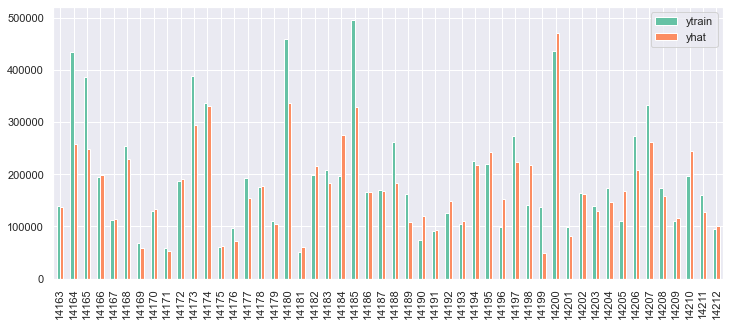

In [62]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytrain": ytrain[14163:14163+50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar")

We see that the predictions are quite reasonable, except for a few cases where the prediction either overshot or undershot the true value by a large amount.

We can retrieve specific instances where the absolute difference between the prediction and the true value was particularly big, say, over 50% of the true value:

In [63]:
cond_idx = np.abs(ytrain[14163:] - yhat)/ytrain[14163:] > 0.5

The number of such cases is:

In [64]:
cond_idx.sum()

172

We can print the corresponding rows in the `trainset` dataframe:

In [65]:
trainset[14163:][cond_idx]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
14190,-0.861076,0.779181,0.606254,-1.194464,-1.269940,-1.288507,-1.304979,0.208745,0.267451,0.020882,1.413809,-0.017829,-0.343423,-0.375228,75000.0
14196,1.256330,-1.428415,-0.996388,0.966974,0.950224,1.501378,0.971541,-0.397354,0.020679,0.035836,-0.707309,-0.017829,-0.343423,2.665046,98300.0
14198,-1.385433,1.063281,1.247310,-0.322893,-0.224018,-0.455938,-0.170704,-0.595284,-0.403281,-0.082123,-0.707309,-0.017829,2.911858,-0.375228,140300.0
14199,-0.836106,1.044651,-0.996388,-1.193531,-1.274782,-1.294918,-1.310292,-0.668041,1.249837,0.017373,1.413809,-0.017829,-0.343423,-0.375228,137500.0
14205,0.687028,-0.366534,-2.118237,-0.236156,-0.357179,-0.467845,-0.428373,0.881670,0.360874,-0.033365,1.413809,-0.017829,-0.343423,-0.375228,111100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15697,1.301275,-1.307323,-1.397048,3.317742,3.049332,3.492583,3.394162,0.318168,0.045212,-0.014675,-0.707309,-0.017829,-0.343423,-0.375228,166100.0
15704,-0.970941,0.634802,-0.755992,-0.110713,-0.345073,-0.267259,-0.356650,0.223921,0.477386,0.000148,1.413809,-0.017829,-0.343423,-0.375228,374600.0
15705,0.612119,-0.762410,1.647971,-0.466523,-0.400759,-0.492575,-0.292897,-0.737802,-0.517230,-0.069356,-0.707309,-0.017829,-0.343423,-0.375228,136600.0
15714,-1.055837,0.495081,-1.316916,7.752537,9.576664,9.817909,10.287475,-0.259810,-0.406454,-0.029242,-0.707309,-0.017829,-0.343423,-0.375228,152800.0


We can inspect these rows more closely to understand potential reasons for the errors. For example, comparing the values in each column with the respective mean and standard deviations, we might find if outliers account for most of these cases.

# Step 6. Evaluate on the test set

Once we found a model that seems to perform well on training data, we can finally evaluate it on the test data.

As with the training data, we need to extract the predictors and the target variables into separate arrays:

In [66]:
# drop labels for training set, but keep all others
Xtest = testset.drop("median_house_value", axis=1)
ytest = testset["median_house_value"].copy()

best_model = grid_search.best_estimator_

yhat = best_model.predict(Xtest)

final_mse = mean_squared_error(ytest, yhat)
final_rmse = np.sqrt(final_mse)
final_rmse

45052.23479976055

The performance on the test set turns out to be very similar to the performance on the training set achieved with cross-validation, but it is not uncommon for it to be somewhat worse than that.

Finally, let's visualize the predictions on the test set.

<AxesSubplot:>

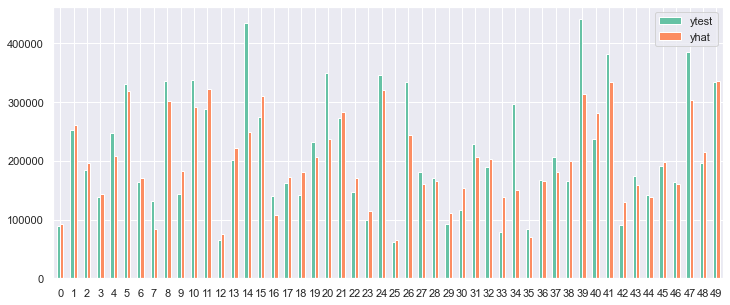

In [67]:
# create a temporary dataframe containing two columns
df_tmp = pd.DataFrame({"ytest": ytest[:50], "yhat": yhat[:50]})

# plot the dataframe
df_tmp.plot(figsize=(12,5), kind="bar", rot=0)

# Acknowledgement

The notebook is based on the code examples from [Aurélien Géron's textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow".

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm